# Q-Learning
## Critic
在之前提到的PG算法和PPO算法都是对policy进行优化，policy是直接控制对环境进行交互行为的。Q-Learning是作为Critic进行训练的，Critic并不会直接决定行为，而是对于给定的策略$\pi$，会评估这个策略的好坏。  
其训练的函数为$V^{\pi}(s)$，该函数代表的函数是对于给定的策略$\pi$，在观察到状态s后，能够获得的累积期望reward。  
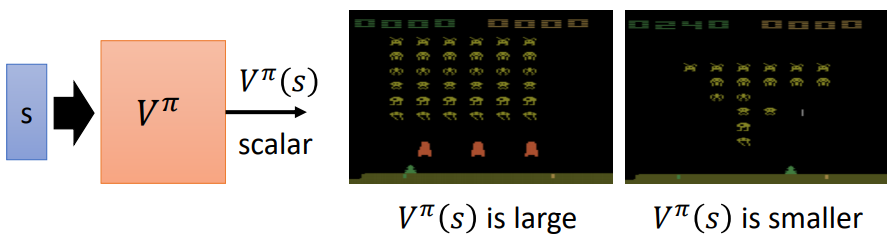  
## how to estimate $V^{\pi}(s)$  
* Monte-Carlo(MC) based approach  
对于给定的状态$s_a$，根据当前的策略$\pi$来进行动作的选择，当一个episode结束时，计算此时累积的收获为$G_a$，则$V^{\pi}(s_a)$要趋近于$G_a$。  
* Temporal-difference(TD) approach  
在某些应用中的episode非常长，此时使用MC算法耗时比较久。我们针对状态$s_t$，采用策略$\pi$获得序列{...$s_t,a_t,r_t,s_{t+1}$...}，根据$V^{\pi}(s)$的定义我们可以得到  
$$V^{\pi}(s_t) = V^{\pi}(s_{t+1}) + r_t$$  
因此此时的训练是让$V^{\pi}(s_t) - V^{\pi}(s_{t+1})$的值趋近于$r_t$。  
## MC v.s. TD  
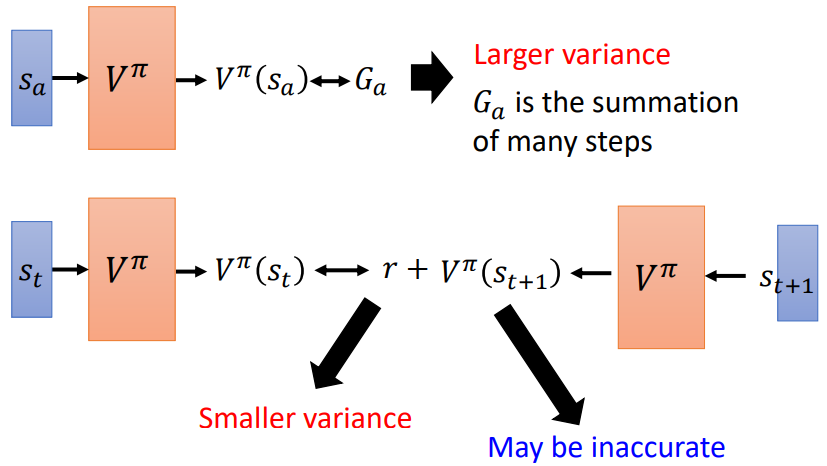  
## Another Critic  
State-Action函数为$Q^{\pi}(s,a)$，其含义为对于给定的策略$\pi$，在观察到状态s并且采取动作a后，能够获得的累积期望reward。  
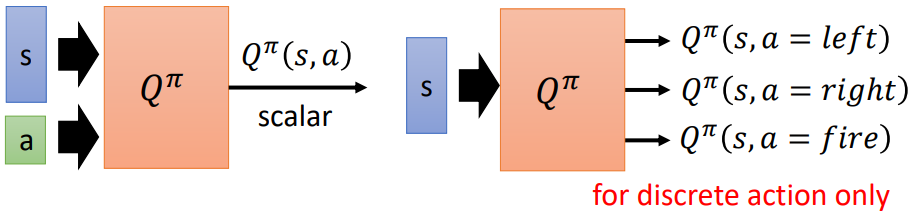  
## Q-Learning
Q-Learning是一种利用Critic来训练策略$\pi$的训练方法，其具体的流程为  
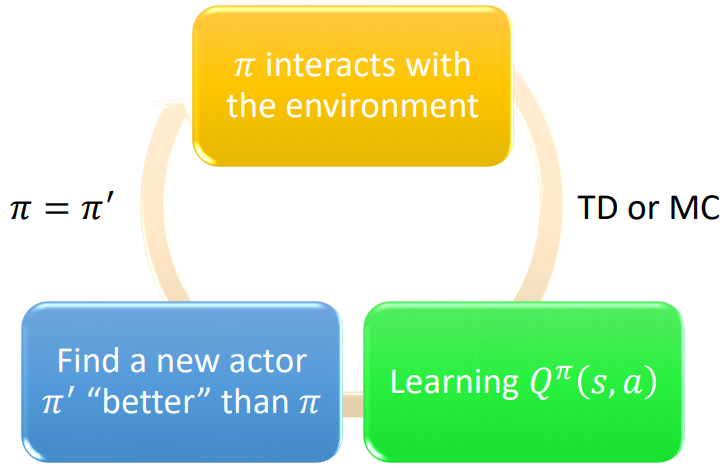  
该流程的问题是我们如何选取$\pi_{'}$并判断其优于$\pi$。在该算法流程中，"Better"的定义为对于任意的状态s，都有$V^{\pi^{'}}(s) \ge V^{\pi}(s)$.  
训练过程中$\pi^{'}$的选取为  
$$\pi_{'}(s) = \arg\max_{a}Q^{\pi}(s,a)$$  
在这个流程中，$\pi^{'}$的选取完全依赖于Q，并且这个方法只适用于此时a可以穷举的情况下，当a为连续值时并不适用，我们稍后会讨论如何解决这个问题。  
我们定义$\pi^{'}(s) = \arg\max_{a}Q^{\pi}(s,a)$，此时如何证明对于任意的状态s都有$V^{\pi^{'}}(s) \ge V^{\pi}(s)$?  
我们有$V^{\pi}(s) = Q^{\pi}(s,\pi(s)) \le max_{a}Q^{\pi}(s,a)=Q^{\pi}(s,\pi^{'}(s))$  
$$\begin{equation}
\begin{aligned}
V^{\pi}(s) &\le Q^{\pi}(s,\pi^{'}(s))\\
&=E[r_{t+1}+V^{\pi}(s_{t+1})|s_t=s,a_t=\pi^{'}(s_t)]\\
&\le E[r_{t+1}+Q^{\pi}(s_{t+1},\pi^{'}(s_{t+1}))|s_t=s,a_t=\pi^{'}(s_t)]\\
&=E[r_{t+1}+r_{t+2}+V^{\pi}(s_{t+2})|...]\\
&\le E[r_{t+1}+r_{t+2}+Q^{\pi}(s_{t+2},\pi^{'}(s_{t+2}))|...]...\\
&\le V^{\pi^{'}}(s)
\end{aligned}
\end{equation}$$  
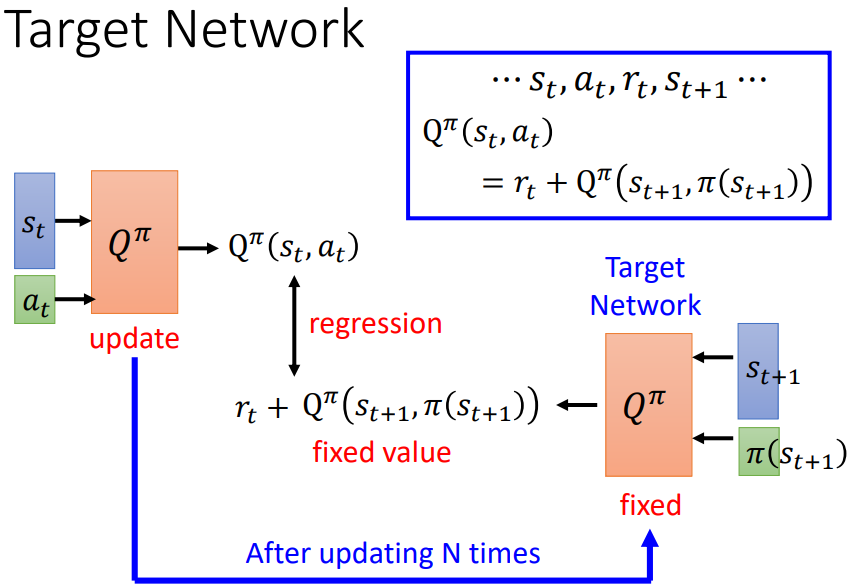  
如上图所示，在训练目标网络$Q^{\pi}$时，通常需要涉及两个网络，如果在更新网络的过程中总是同时更新两个网络，则我们很难训练出一个合适的网络，因此在实际训练过程中，我们通常会先固定一个网络的参数，然后在另一个网络更新几个回合后再去更新其参数。  
* Exploration  
在训练过程中，如果我们从抽取的所有样本中选择出s状态下能够获得最大reward的a后，就不在去探索其他的可能性，那么可能存在一些能够获得更高reward的动作a没有被抽样到，导致永远不会采取这个action，这样是不合理的，因此我们需要增加exploration的操作，其具体实现如下图所示。  
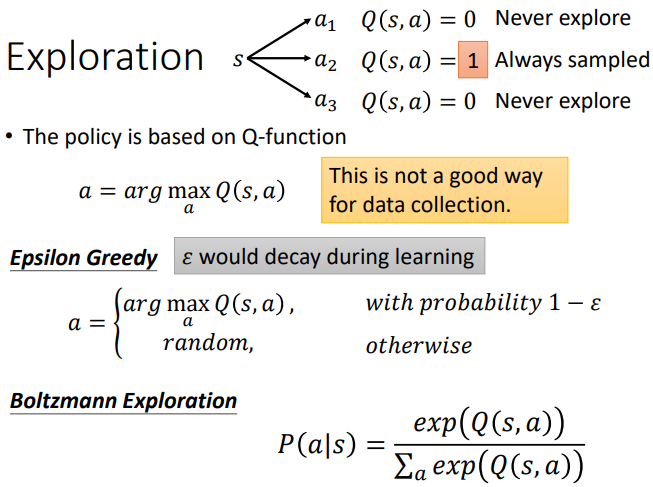  
* Replay Buffer  
在进行Q-Learning的过程中，我们将策略$\pi$收集的用于训练exp({$s_t,a_t,r_t,s_{t+1}$})存放在buffer中，每次训练Q的时候会随机从buffer中抽取小批量的样本进行训练，只有当buffer满了才会清空buffer，因此在训练Q时用到的exp可能来自不同的策略。  
Q-Learning训练算法如下所示：  
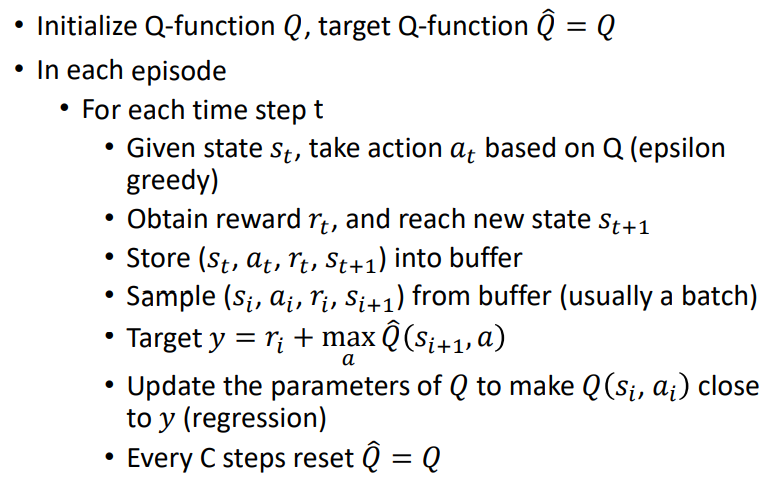  
# Tips of Q-Learning
## Double DQN
在Q函数的实际训练过程中，Q值经常会估计过高，如下图所示。  
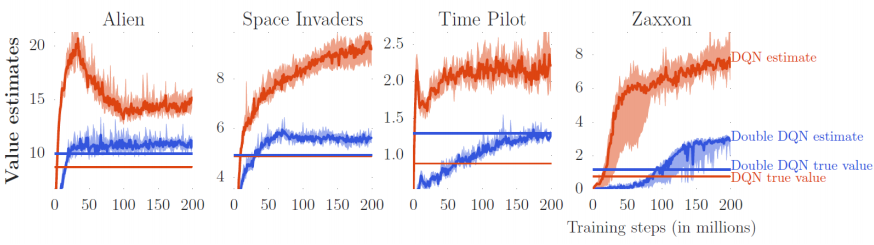  
因此在训练过程中，训练的目标是$Q(s_t,a_t)$趋近于$r_t+\max_aQ(s_{t+1},a)$。由于是取最大值，因此这时选择的action很可能是估计过高的。  
为了避免这种情况，我们修改训练的目标，将其修改为：  
$$Q(s_t,a_t) \leftrightarrow r_t + Q^{'}(s_{t+1},\arg\max_aQ(s_{t+1},a))$$  
其中网络Q代表我们正在训练的网络，而Q^{'}代表的是Target Network，会在几个回合里固定。此时，当Q估计过高时，$Q^{'}$会提供合适的值，而$Q^{'}$估计过高的值，Q不会选取。  
## Dueling DQN  
该方法修改训练网络的结构，如下图所示。  
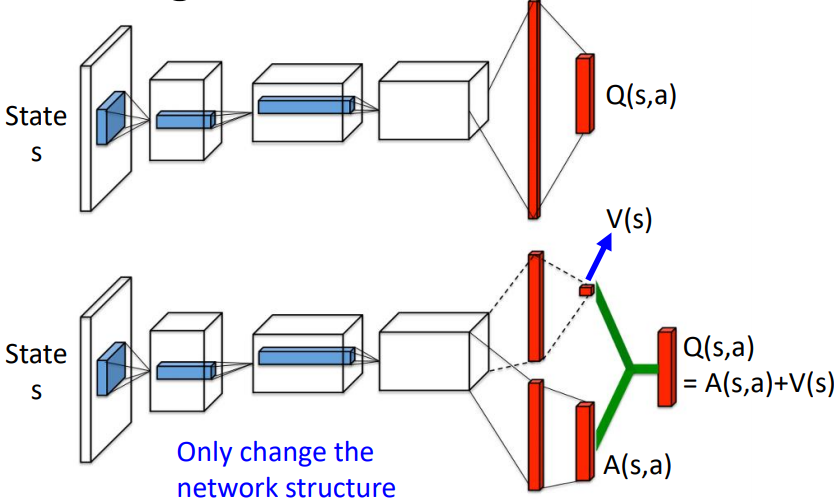  
将输出的结构修改为一个标量和某个state时对应所有action的值，因此为了修改某个state下的action时，我们只需要修改该标量值即可。但在训练过程中，为了避免修改的时action列表，我们需要对输出做一定的限制。  
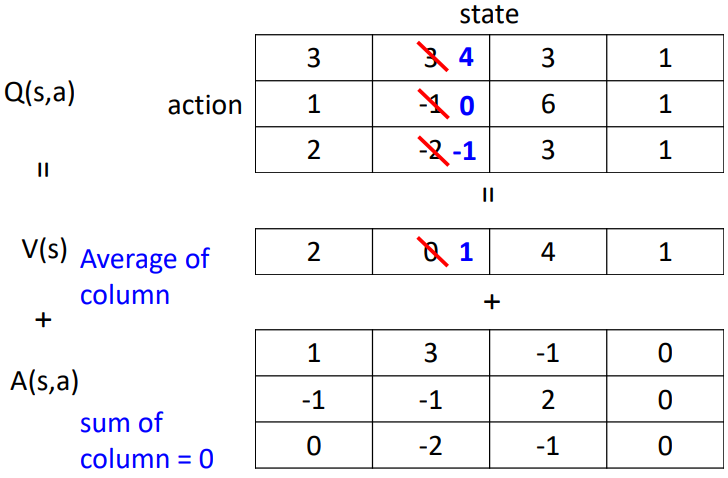  
因为增加了该限制，所以我们在将A(s,a)与V(s)相加前，要先对其做归一化处理。  
## Prioritized Reply  
之前提到过，我们训练的数据是从exp buffer中随机抽取的，在buffer中的数据存在一些TD error相差比较大的样本，对于这部分样本应该提高其被抽取到的概率。  
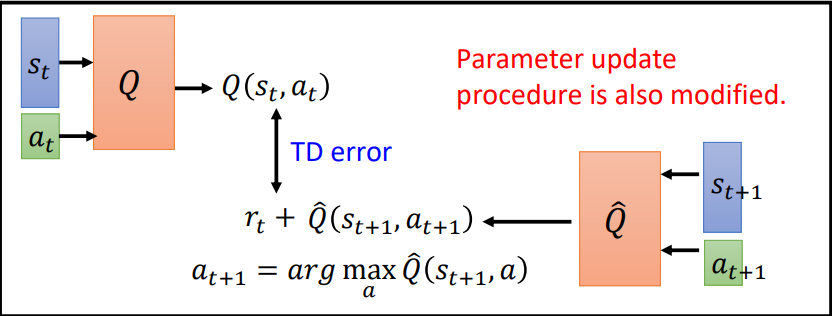  
## Multi-Step
该建议是为了平衡MC和TD，在原本的训练过程中，我们只会抽取{$s_t,a_t,r_t,s_{t+1}$}这样的序列，准确率可能会比较低，我们结合MC算法，抽取的序列改为{s_t,a_t,r_t,...,s_{t+N},a_{t+N},r_{t+N},s_{t+N+1}}，通过权衡方差和准确率之间的关系选择合适的N值。  
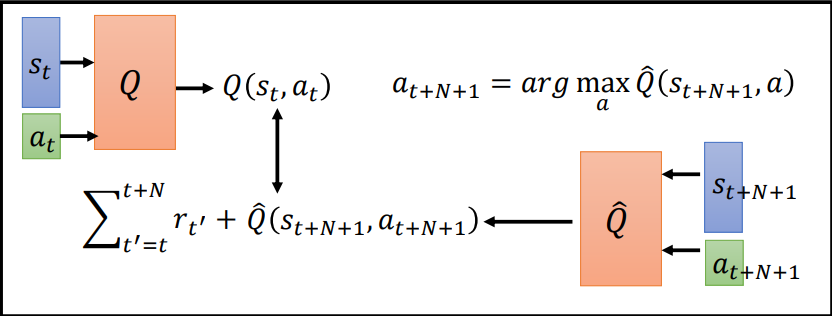  
## Noisy Net  
我们之前提到了，为了在训练过程中保持exploration，需要对于动作的选择增加一个随机的策略，这样子在一个episode中，同一个state可能会有不同的动作选择，相当于是随机的乱试，这样不太合理。因此修改策略，在每个episode开始之前，向Q网络随机增加噪音，然后在episode中不再使用随机选择，而是以一种一致的方式进行探索，相当于有系统的尝试。  
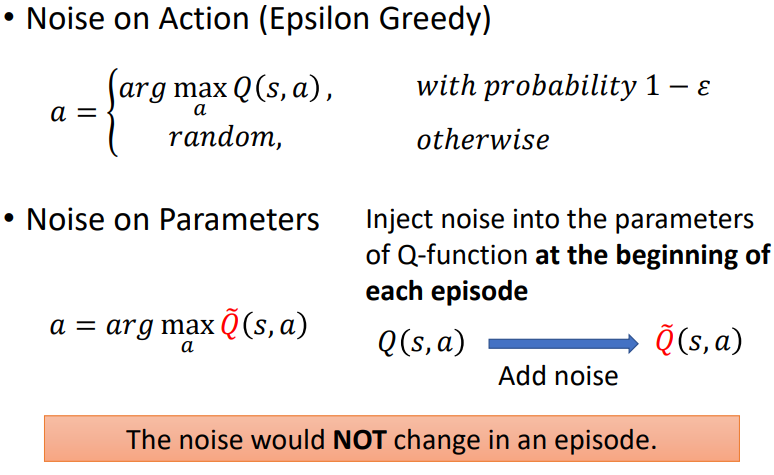  
## Distributional Q-function  
对于$Q^{\pi}(s,a)$，我们获取的是累积reward的期望值，然后对于不同reward的分布可能有相同的期望值，因此我们在训练过程中输出的不是期望值，而是该Q的分布。  
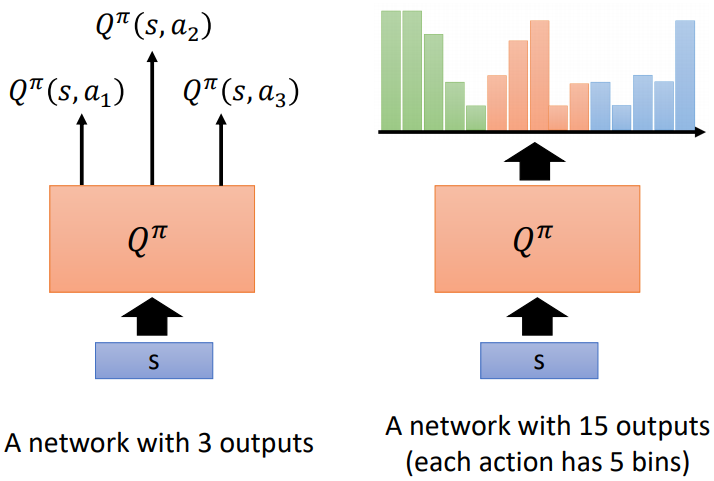  
# Q-Learning For Continuous Action  
上述的Q-Learning都是针对action为可穷举情况，现在考虑a为连续值的情况。  
定义动作a为连续向量，$a = \arg\max_aQ(s,a)$
* Solution 1:随机抽取一定的Action{$a_1,a_2,...,a_N$}，然后查找是Q值最大的a。  
* Solution 2：使用梯度上升方法来解决该优化问题，但这样计算量比较大。
* Solution 3：设计一个网络来使得优化问题简单化。  
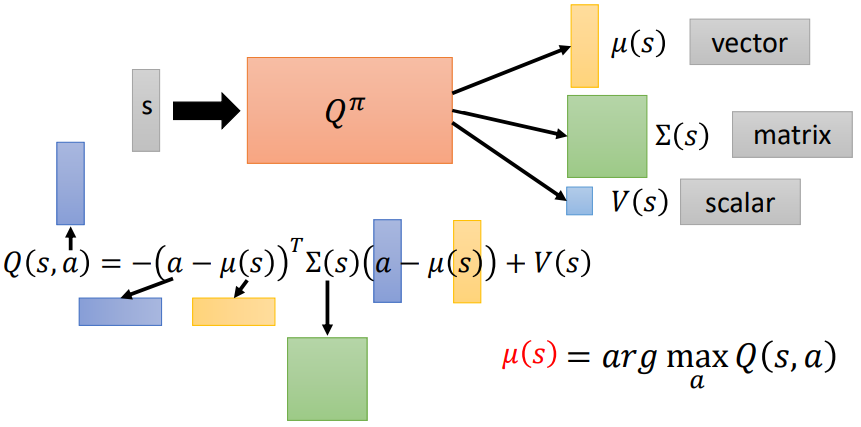
* Solution 4：不使用Q-Learning